<a href="https://colab.research.google.com/github/enakai00/JAX_workshop/blob/main/2_MNIST_Softmax_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 多項分類器によるMNISTデータセットの分類

## 事前準備

JAX/Flax/Optax のライブラリーをインストールします。

In [ ]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.25
jaxlib                        0.3.25+cuda11.cudnn805
optax                         0.1.3


使用するモジュールをインポートします。

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from tensorflow.keras.datasets import mnist

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state

plt.rcParams.update({'font.size': 12})

MNISTデータセットをダウンロードします。

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

画像のサンプルを表示します。

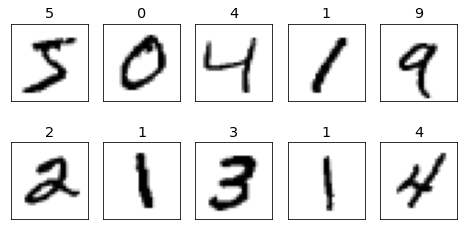

In [ ]:
fig = plt.figure(figsize=(8, 4))
for c, (image, label) in enumerate(zip(train_images[:10], train_labels[:10])):
    subplot = fig.add_subplot(2, 5, c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(label))
    subplot.imshow(image.reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

学習データをバッチに分割する関数を用意します。

In [ ]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

## 機械学習モデルの定義

Flax の linen モジュールを用いて、機械学習モデルを定義します。

ここでは、10個の1次関数とソフマックス関数で、10種類の文字に対するそれぞれの確率を計算する線形多項分類器を定義します。

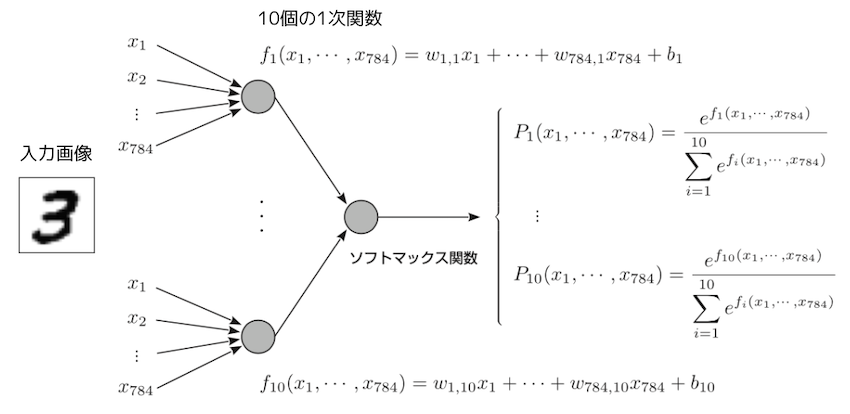

`nn.Module` クラスを継承して、次のような形式でモデルのクラスを定義します。

In [ ]:
class SoftmaxEstimationModel(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False):
        x = nn.Dense(features=10)(x)    # 10 個の1次関数からなるレイヤー
        if get_logits:                  # オプション get_logits=True を指定した場合は、確率値に変換する前の1次関数の値（ロジット）を返却
            return x
        x = nn.softmax(x)               # ソフトマックス関数で10種類の確率値に変換
        return x

## モデルの学習状態を管理する TrainState オブジェクトを作成

学習対象となるモデルのパラメーター値の初期値を乱数で生成します。

`init()` メソッドには、乱数のシードと入力データのサンプル（1サンプルで十分です）を受け渡します。入力データのサンプルは、入力データのサイズを判断するために使用されます。

In [ ]:
key, key1 = random.split(random.PRNGKey(0))
variables = SoftmaxEstimationModel().init(key1, train_images[0:1])

生成されたパラメーター値は、`params` を親キーとするツリー形式のディクショナリーに格納されています。

In [ ]:
variables

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[ 0.01657388,  0.00152772,  0.05613703, ..., -0.03002504,
                          -0.01127076, -0.00081298],
                         [-0.03016399,  0.07627734,  0.05284328, ...,  0.00274584,
                          -0.03705769,  0.05050171],
                         [ 0.0083269 , -0.02451643,  0.00528112, ...,  0.03774479,
                           0.03392191,  0.02328875],
                         ...,
                         [ 0.04172773,  0.00685237,  0.01950883, ...,  0.07278462,
                          -0.01973733,  0.01945721],
                         [-0.04342256,  0.00439465, -0.02705162, ..., -0.01330197,
                          -0.01026833,  0.00130465],
                         [-0.03812302, -0.01401596, -0.04480863, ..., -0.02282006,
                          -0.03536371, -0.0008738 ]], dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float

モデルの学習状態を管理する TrainState オブジェクトを作成します。

このオブジェクトには、次のような情報を格納します。

*   `apply_fn`: モデルの予測値を取得するメソッド
*   `params`: モデルのパラメーター値（`params` キー以下の内容）
*   `tx`: 学習に使用するアルゴリズム（ここでは、Adam Optimizer を指定）


In [ ]:
state = train_state.TrainState.create(
    apply_fn=SoftmaxEstimationModel().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

## 学習に使用する関数を定義

誤差関数を定義します。誤差関数の勾配ベクトルを用いて、誤差関数の値が小さくなるようにパラメーターの学習処理が行われます。

ここでは、モデルが出力するロジットの値から計算されるクロスエントロピーを誤差関数として使用します。

In [ ]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

誤差関数の勾配ベクトルを計算して、パラメーターの修正を1回だけ行う関数を定義します。

In [ ]:
@jax.jit
def train_step(state, inputs, labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

バッチに分割された学習データを1エポック分だけ学習する関数を定義します。

すべての学習データをちょうど1回だけ使用することを「1エポック」と言います。

In [ ]:
def train_epoch(state, input_batched, label_batched, eval):
    loss_history, acc_history = [], []
    for inputs, labels in zip(input_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, labels)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

指定回数のエポック分だけ学習を繰り返す関数 `fit()` を定義します。

In [ ]:
def fit(state, train_inputs, train_labels, test_inputs, test_labels,
        epochs, batch_size):

    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched = create_batches(test_labels, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(1, epochs+1):
        # Training
        state, loss_train, acc_train = train_epoch(
            state, train_inputs_batched, train_labels_batched, eval=False)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        # Evaluation
        _ , loss_test, acc_test = train_epoch(
            state, test_inputs_batched, test_labels_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f} / '.format(
            epoch, loss_train, acc_train), end='', flush=True)
        print ('Loss(Test): {:.4f}, Accuracy(Test): {:.4f}'.format(
            loss_test, acc_test), flush=True)
  
    history = {'loss_train': loss_history_train,
               'acc_train': acc_history_train,
               'loss_test': loss_history_test,
               'acc_test': acc_history_test}
  
    return state, history

## 学習処理の実行

先ほど用意した関数 `fit()` を用いて、学習を実行します。

16エポックの学習で、テストセットに対して、約92%の正解率を達成します。

In [ ]:
%%time
state, history = fit(state, 
                     train_images, train_labels, test_images, test_labels,
                     epochs=16, batch_size=128)

Epoch: 1, Loss: 0.6755, Accuracy: 0.8390 / Loss(Test): 0.3840, Accuracy(Test): 0.9004
Epoch: 2, Loss: 0.3670, Accuracy: 0.9008 / Loss(Test): 0.3202, Accuracy(Test): 0.9125
Epoch: 3, Loss: 0.3240, Accuracy: 0.9109 / Loss(Test): 0.2970, Accuracy(Test): 0.9168
Epoch: 4, Loss: 0.3039, Accuracy: 0.9159 / Loss(Test): 0.2852, Accuracy(Test): 0.9202
Epoch: 5, Loss: 0.2918, Accuracy: 0.9190 / Loss(Test): 0.2782, Accuracy(Test): 0.9216
Epoch: 6, Loss: 0.2835, Accuracy: 0.9214 / Loss(Test): 0.2736, Accuracy(Test): 0.9227
Epoch: 7, Loss: 0.2774, Accuracy: 0.9227 / Loss(Test): 0.2704, Accuracy(Test): 0.9241
Epoch: 8, Loss: 0.2726, Accuracy: 0.9238 / Loss(Test): 0.2681, Accuracy(Test): 0.9242
Epoch: 9, Loss: 0.2688, Accuracy: 0.9249 / Loss(Test): 0.2665, Accuracy(Test): 0.9251
Epoch: 10, Loss: 0.2656, Accuracy: 0.9259 / Loss(Test): 0.2652, Accuracy(Test): 0.9259
Epoch: 11, Loss: 0.2629, Accuracy: 0.9268 / Loss(Test): 0.2642, Accuracy(Test): 0.9262
Epoch: 12, Loss: 0.2605, Accuracy: 0.9274 / Loss(Tes

トレーニングセット、テストセット、それぞれに対する正解率、および、誤差関数の変化をグラフ表示します。

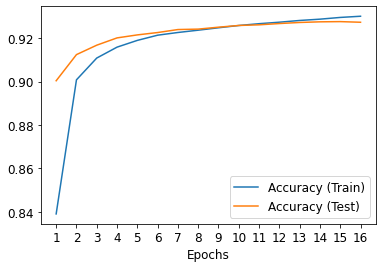

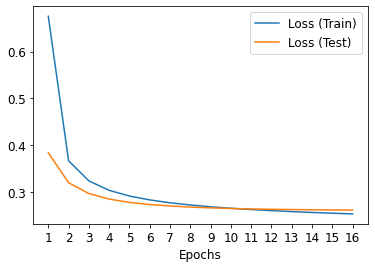

In [ ]:
df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

学習後のモデルによる予測結果を表示します。左の3列は正解パターンで、右の3列は不正解パターンになります。

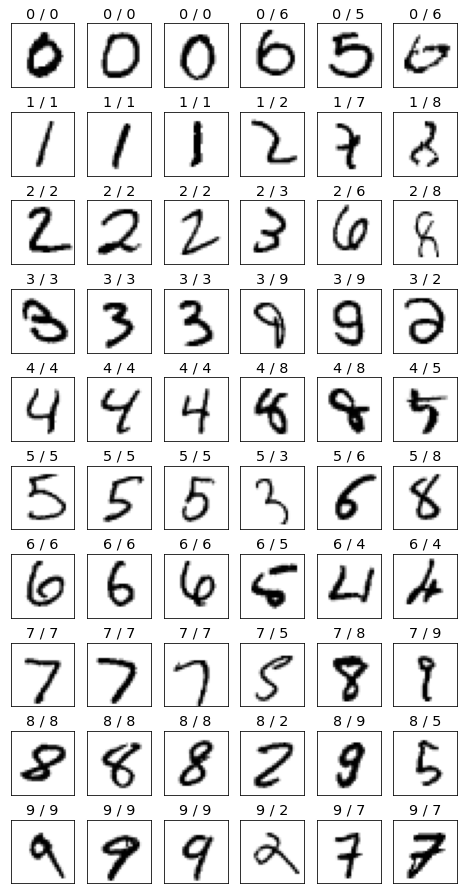

In [ ]:
predictions = jax.device_get(
    state.apply_fn({'params': state.params}, test_images))

df = DataFrame({'pred': list(map(np.argmax, predictions)),
                'label': list(map(np.argmax, jax.device_get(test_labels)))})
correct = df[df['pred']==df['label']]
incorrect = df[df['pred']!=df['label']]

fig = plt.figure(figsize=(8, 16))
for i in range(10):
    indices = list(correct[correct['pred']==i].index[:3]) \
                + list(incorrect[incorrect['pred']==i].index[:3])
    for c, image in enumerate(test_images[indices]):
        subplot = fig.add_subplot(10, 6, i*6+c+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.set_title('{} / {}'.format(i, df['label'][indices[c]]))
        subplot.imshow(image.reshape([28, 28]),
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

## 隠れ層を追加してモデルを拡張

先ほどのモデルに対して、1024個のノードを持つ隠れ層を追加した、新しいモデルを定義します。

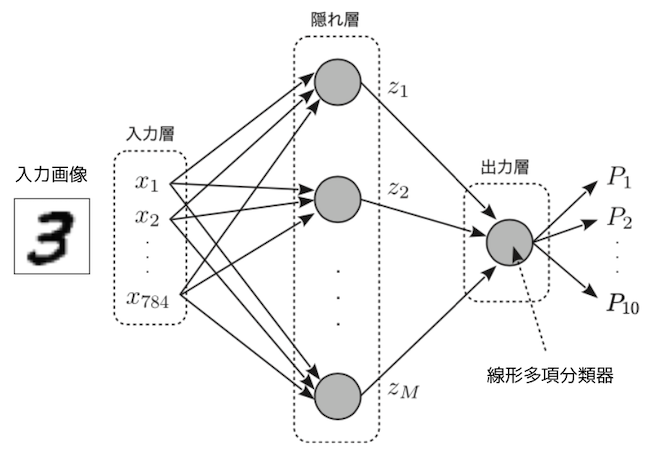

In [ ]:
class SingleLayerSoftmaxModel(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False):
        x = nn.Dense(features=1024)(x)  # 1024個のノードからなる隠れ層を追加
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

新しいモデルのパラメーターの初期値を生成して、モデルの学習状態を管理する TrainState オブジェクトを作成します。

In [ ]:
key, key1 = random.split(random.PRNGKey(0))
variables = SingleLayerSoftmaxModel().init(key1, train_images[0:1])

state = train_state.TrainState.create(
    apply_fn=SingleLayerSoftmaxModel().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

関数 `fit()` を用いて、16 エポック分の学習を行います。今回は、テストセットに対して、98%の正解率を達成します。

In [ ]:
%%time
state, history = fit(state, 
                     train_images, train_labels, test_images, test_labels,
                     epochs=16, batch_size=128)

Epoch: 1, Loss: 0.2681, Accuracy: 0.9236 / Loss(Test): 0.1562, Accuracy(Test): 0.9505
Epoch: 2, Loss: 0.1033, Accuracy: 0.9691 / Loss(Test): 0.1108, Accuracy(Test): 0.9645
Epoch: 3, Loss: 0.0631, Accuracy: 0.9814 / Loss(Test): 0.0861, Accuracy(Test): 0.9725
Epoch: 4, Loss: 0.0412, Accuracy: 0.9889 / Loss(Test): 0.0733, Accuracy(Test): 0.9768
Epoch: 5, Loss: 0.0279, Accuracy: 0.9927 / Loss(Test): 0.0733, Accuracy(Test): 0.9768
Epoch: 6, Loss: 0.0188, Accuracy: 0.9956 / Loss(Test): 0.0792, Accuracy(Test): 0.9759
Epoch: 7, Loss: 0.0128, Accuracy: 0.9972 / Loss(Test): 0.0729, Accuracy(Test): 0.9770
Epoch: 8, Loss: 0.0093, Accuracy: 0.9980 / Loss(Test): 0.0728, Accuracy(Test): 0.9798
Epoch: 9, Loss: 0.0108, Accuracy: 0.9972 / Loss(Test): 0.0774, Accuracy(Test): 0.9790
Epoch: 10, Loss: 0.0089, Accuracy: 0.9978 / Loss(Test): 0.0874, Accuracy(Test): 0.9766
Epoch: 11, Loss: 0.0082, Accuracy: 0.9977 / Loss(Test): 0.0790, Accuracy(Test): 0.9799
Epoch: 12, Loss: 0.0063, Accuracy: 0.9982 / Loss(Tes

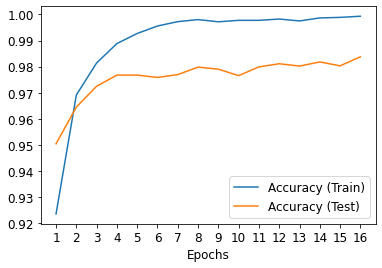

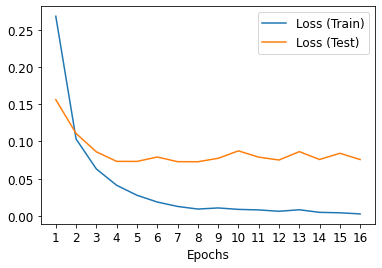

In [ ]:
df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

## 文字認識アプリを作成

JavaScript でホワイトキャンバスを表示して、手描き文字（数字）を入力します。

In [ ]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e) {
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0, 0, 0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY*0.2);
            y = Math.floor(e.offsetX*0.2) + 1;
            for (var dy = 0; dy < 2; dy++) {
                for (var dx = 0; dx < 2; dx++) {
                    if ((x + dx < 28) && (y + dy < 28)) {
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });
    
    function set_value() {
        var result = "";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        google.colab.kernel.invokeFunction(
                          'notebook.set_image', [result], {});
    }
    
    function clear_value() {
        canvas.getContext("2d").fillStyle = "rgb(255, 255, 255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
"""

from google.colab import output  
from IPython.display import HTML

def set_image(result):
    global image
    image = np.array([float(x) for x in result.split(',')[:-1]])

image = np.zeros([28*28])
output.register_callback('notebook.set_image', set_image)

HTML(input_form + javascript)

入力した画像に対する予測結果を表示します。

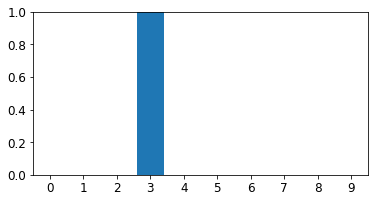

In [ ]:
input_data = image.reshape([1, 28*28])
predictions = jax.device_get(
    state.apply_fn({'params': state.params}, input_data))
predictions = predictions[0]

fig = plt.figure(figsize=(6, 3))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks(range(10))
subplot.set_xlim([-0.5, 9.5])
subplot.set_ylim([0, 1])
_ = subplot.bar(range(10), predictions, align='center')